In [1]:
!pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 4.9 MB/s 


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.7 MB/s 
     |████████████████████████████████| 163 kB 62.6 MB/s 


In [3]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
import pandas as pd
import seaborn as sns
from transformers import BertTokenizer, TFBertModel, BertConfig


In [4]:
df = pd.read_csv("categorical_data.csv")
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


Text(0.5, 1.0, 'Tweets distribution by cyberbullying types')

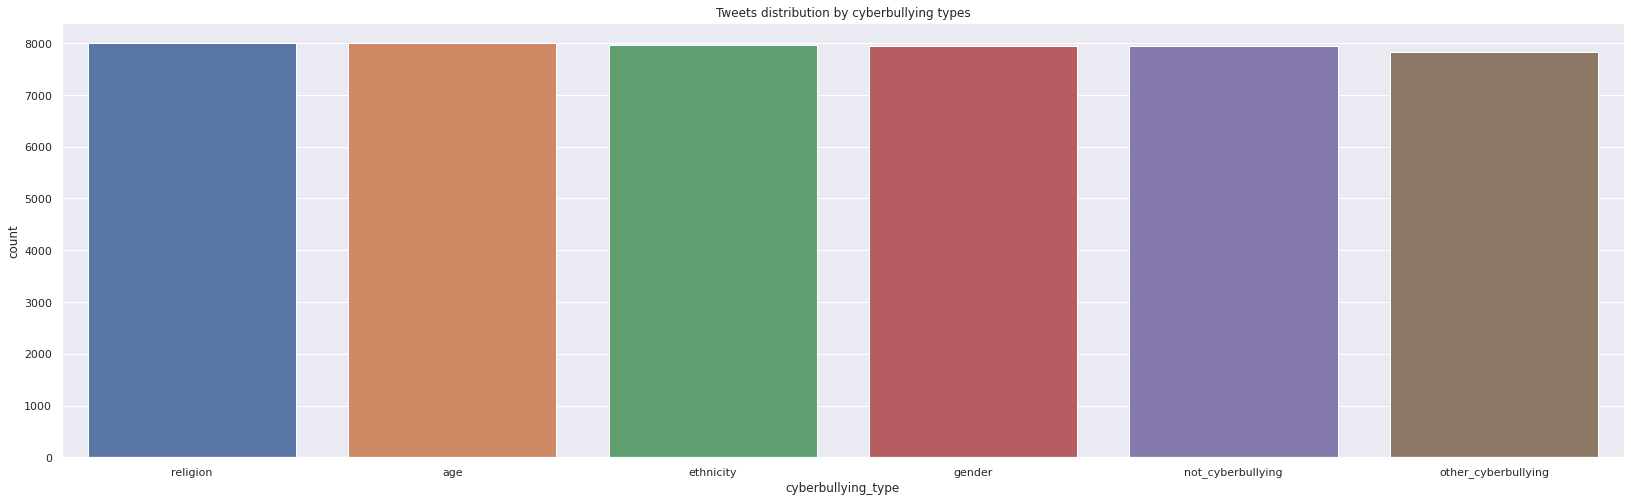

In [5]:
df = df.drop_duplicates()
sns.set(rc={'figure.figsize':(28,8)})
sns.countplot(x="cyberbullying_type", data=df, order=df.cyberbullying_type.value_counts().index).set_title("Tweets distribution by cyberbullying types")

Text(0.5, 1.0, 'Tweets distribution by cyberbullying types')

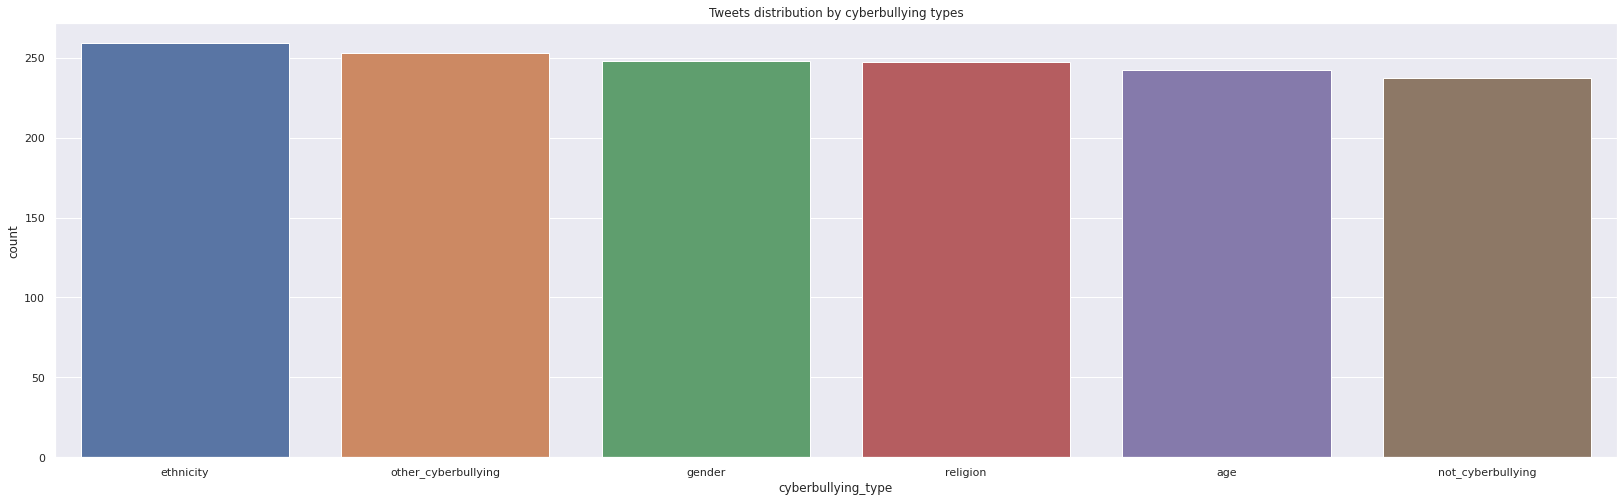

In [6]:
classes=list(df["cyberbullying_type"].unique())
df_list=[]

flux=700-800+800
for i in range(len(classes)):
    sub_df=df[df["cyberbullying_type"]==classes[i]]
    #drop first 7000 rows of sub_df
    if (classes[i]=="other_cyberbullying"):
        sub_df=sub_df.drop(sub_df.index[:6870+flux])
    elif (classes[i]=="religion"):
        sub_df=sub_df.drop(sub_df.index[:7050+flux])
    elif (classes[i]=="age"):
        sub_df=sub_df.drop(sub_df.index[:7050+flux])       
    else:
        sub_df=sub_df.drop(sub_df.index[:7000+flux])
    df_list.append(sub_df)


#concatenate all sub_df
df_dropped=pd.concat(df_list)
df_drop=df_dropped.reset_index()


df = df_drop
sns.set(rc={'figure.figsize':(28,8)})
sns.countplot(x="cyberbullying_type", data=df, order=df.cyberbullying_type.value_counts().index).set_title("Tweets distribution by cyberbullying types")

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [8]:

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

def initial_cleaning(text):
    text = re.sub(r"^RT[\s]+","",text)
    text = text.lower()
    text = re.sub(r"https?:\/\/.*[\r\n]*","https",text)
    text = re.sub(r"@[A-Za-z0-9]+","",text)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U00002600-\U000026FF"  # Miscellaneous Symbols
        u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols And Pictographs
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
                           "]+", flags=re.UNICODE)

    text=emoji_pattern.sub(r'', text)
    text = re.sub(r'[0-9]',' ',text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    return text

def remove_stopword(text):
    a = [i for i in text.split() if i not in stopwords.words('english')]
    return ' '.join(a)

porter = PorterStemmer()
def stem(text):
    a = [porter.stem(i) for i in text.split()]
    return ' '.join(a)

porter = PorterStemmer()
def stem(text):
    a = [porter.stem(i) for i in text.split()]
    return ' '.join(a)

wl = WordNetLemmatizer()
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

tokenizer = TweetTokenizer(preserve_case=False, 
                           strip_handles=True,
                           reduce_len=True)
def lemmatizer(text):
    word_pos_tags = nltk.pos_tag(tokenizer.tokenize(text))
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)



def text_preprocessing(text):
    return lemmatizer(stem(remove_stopword(initial_cleaning(text))))

df["original_tweet"] = df.tweet_text
df.tweet_text = df.tweet_text.apply(lambda x: text_preprocessing(x))
df

,index,tweet_text,cyberbullying_type,original_tweet
0,7707,get skin realli crispi burn aliv front famili mkr,not_cyberbullying,RT @GordyPls: To get the skin really crispy yo...
1,7708,babi headach love smile frown wrong right pain...,not_cyberbullying,"You're my baby, my headache, my love, my smile..."
2,7709,want go space look cool,not_cyberbullying,I want to go to space. It looks cool.
3,7710,colin dip end mkr,not_cyberbullying,A 7! Colin dipping his end in! #mkr
4,7711,thank xxx,not_cyberbullying,@TTLoverLaura thanks!! Me too xxx
...,...,...,...,...
1481,47687,black ppl expect anyth depend anyth yet free p...,ethnicity,"Black ppl aren't expected to do anything, depe..."
1482,47688,turner withhold disappoint turner call court “...,ethnicity,Turner did not withhold his disappointment. Tu...
1483,47689,swear god dumb nigger bitch get bleach hair re...,ethnicity,I swear to God. This dumb nigger bitch. I have...
1484,47690,yea fuck rt your nigger fuck unfollow fuck dum...,ethnicity,Yea fuck you RT @therealexel: IF YOURE A NIGGE...


In [9]:
import imp
from nltk.util import ngrams
from gensim.models import Word2Vec
import multiprocessing
from time import time  # To time our operations
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

text_list_p=df["tweet_text"].tolist()
labels_p=df["cyberbullying_type"].tolist()

text_list=[]
labels=[]
for i in range(len(labels_p)):
    if text_list_p[i]!='':
        text_list.append(text_list_p[i])
        labels.append(labels_p[i])

labels=np.array(labels)


label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
num_classes=int(np.max(integer_encoded)+1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
mapping = dict(zip(label_encoder.classes_, onehot_encoder.transform(label_encoder.transform(label_encoder.classes_).reshape(num_classes, 1))))
for key,value in mapping.items():
    print("",key," ----------------------------- ",value)




omega_text_words = []
n=1
cores = multiprocessing.cpu_count() # Count the number of cores in a computer


for i in range(len(text_list)):
    sentence=text_list[i]
    unigrams = ngrams(sentence.split(), n)
    flat_list = [item for sublist in [list(a) for a in unigrams] for item in sublist]
    omega_text_words.append(flat_list)

 age  -----------------------------  [1. 0. 0. 0. 0. 0.]
 ethnicity  -----------------------------  [0. 1. 0. 0. 0. 0.]
 gender  -----------------------------  [0. 0. 1. 0. 0. 0.]
 not_cyberbullying  -----------------------------  [0. 0. 0. 1. 0. 0.]
 other_cyberbullying  -----------------------------  [0. 0. 0. 0. 1. 0.]
 religion  -----------------------------  [0. 0. 0. 0. 0. 1.]


In [10]:
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
#shuffler
def unison_shuffled_copies(a, b,c):
    assert len(a) == len(b==len(c))
    p = np.random.permutation(len(a))
    return a[p], b[p],c[p]


t=Tokenizer()
t.fit_on_texts(text_list)
vocab_size = len(t.word_index) + 1
X_encoded= t.texts_to_sequences(text_list)
max_len=max(len(l) for l in X_encoded)


Y=tf.keras.utils.to_categorical(integer_encoded, num_classes=6)

tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")
X_bert = [tokenizer_bert(text, padding='max_length', max_length = max_len, truncation=True)['input_ids'] for text in text_list]
X_bert = np.array(X_bert, dtype='int32')
Mask_bert= [tokenizer_bert(text, padding='max_length', max_length = max_len, truncation=True)['attention_mask'] for text in text_list]
Mask_bert = np.array(Mask_bert, dtype='int32')
X=X_bert
Z=Mask_bert





X,Y,Z=unison_shuffled_copies(X, Y,Z)


# Split the dataset
val_split_percent=0.2
test_split_percent=0.1
split_train = int(len(X)*(1-val_split_percent-test_split_percent))
split_valid = int(len(X)*(1-test_split_percent))

# Train
X_train = X[:split_train, :]; y_train=Y[:split_train, :]; z_train=Z[:split_train, :]

# Valid
X_valid = X[split_train:split_valid,:]; y_valid=Y[split_train:split_valid,:]; z_valid=Z[split_train:split_valid,:]

# Test
X_test = X[split_valid:,:]; y_test=Y[split_valid:,:]; z_test=Z[split_valid:,:]

   
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

(1036, 40) (1036, 6)
(296, 40) (296, 6)
(148, 40) (148, 6)


In [12]:
config = BertConfig(dropout=0.2, attention_dropout=0.2)
dbert = TFBertModel.from_pretrained("bert-base-uncased", config=config, trainable=False)

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [13]:
from tensorflow.keras import models

input_ids_in = layers.Input(shape=(max_len,), name='input_token', dtype='int32')
masks= layers.Input(shape = (max_len,), dtype='int32')
x = dbert(input_ids=input_ids_in,attention_mask=masks)[0][:,0,:]
x= layers.Dense(512,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(x)
x= layers.Dropout(0.5)(x)
x= layers.Dense(256,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(x)
x= layers.Dropout(0.5)(x)
x = layers.Dense(6, activation='softmax', name='classification')(x)

dmodel = models.Model(inputs=[input_ids_in,masks], outputs = x)

dmodel.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss='categorical_crossentropy', metrics=['accuracy'])
dmodel.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 40)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_token[0][0]',            
                                thPoolingAndCrossAt               'input_1[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 40,                                            

In [14]:
history = dmodel.fit([X_train,z_train], y_train, batch_size=64, shuffle=True, epochs=50, validation_data=([X_valid,z_valid], y_valid))

Epoch 1/50
17/17 [==============================] - 19s 394ms/step - loss: 10.0005 - accuracy: 0.2539 - val_loss: 8.1037 - val_accuracy: 0.5304
Epoch 2/50
17/17 [==============================] - 4s 208ms/step - loss: 7.1595 - accuracy: 0.3600 - val_loss: 5.8039 - val_accuracy: 0.5304
Epoch 3/50
17/17 [==============================] - 3s 208ms/step - loss: 5.2788 - accuracy: 0.4604 - val_loss: 4.3593 - val_accuracy: 0.5845
Epoch 4/50
17/17 [==============================] - 4s 209ms/step - loss: 4.0713 - accuracy: 0.5521 - val_loss: 3.4817 - val_accuracy: 0.5777
Epoch 5/50
17/17 [==============================] - 4s 210ms/step - loss: 3.3353 - accuracy: 0.5666 - val_loss: 2.8960 - val_accuracy: 0.6284
Epoch 6/50
17/17 [==============================] - 4s 209ms/step - loss: 2.8243 - accuracy: 0.5878 - val_loss: 2.5195 - val_accuracy: 0.6182
Epoch 7/50
17/17 [==============================] - 4s 210ms/step - loss: 2.4694 - accuracy: 0.6197 - val_loss: 2.2303 - val_accuracy: 0.6689
Epoc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 4.6 MB/s 


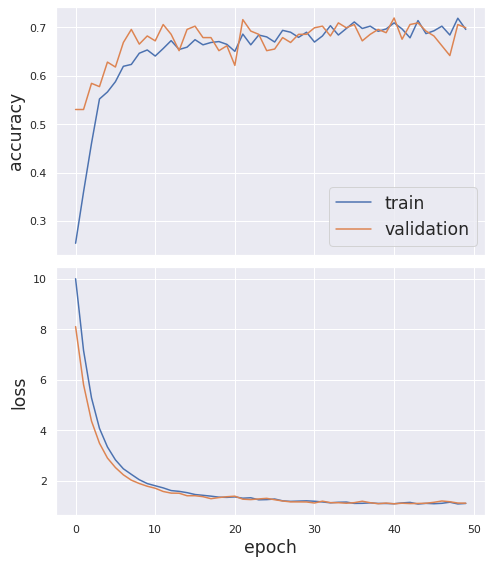

In [15]:
!pip install stellargraph
import stellargraph as sg
sg.utils.plot_history(history)

In [16]:
_, acc = dmodel.evaluate([X_test,z_test], y_test)
print("Accuracy = ", (acc * 100.0), "%")

5/5 [==============================] - 1s 100ms/step - loss: 1.0797 - accuracy: 0.7095
Accuracy =  70.94594836235046 %


5/5 [==============================] - 4s 94ms/step


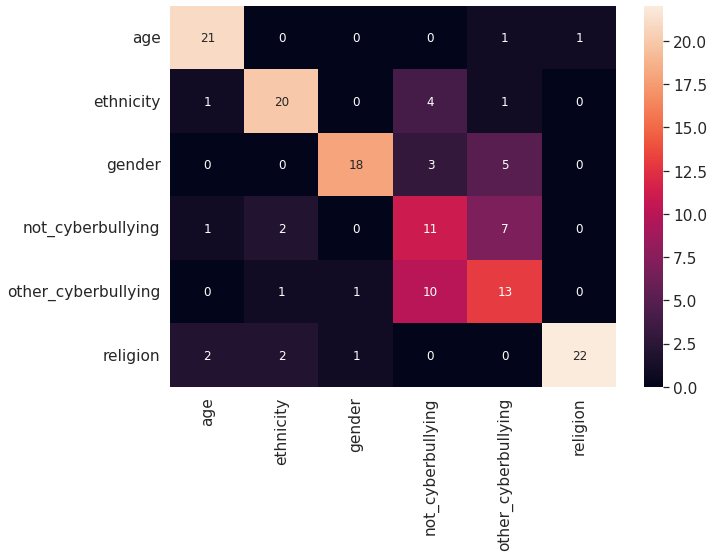

In [17]:
ref=np.argmax(y_test,axis=1)
predictions=np.argmax(dmodel.predict([X_test,z_test]),axis=1)
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ref,predictions)



label_names=[]
for key,_ in mapping.items():
    label_names.append(key)

    
#plot confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, label_names,label_names)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size

In [18]:
from sklearn.metrics import classification_report

print(classification_report(ref, predictions,digits=4))

              precision    recall  f1-score   support

           0     0.8400    0.9130    0.8750        23
           1     0.8000    0.7692    0.7843        26
           2     0.9000    0.6923    0.7826        26
           3     0.3929    0.5238    0.4490        21
           4     0.4815    0.5200    0.5000        25
           5     0.9565    0.8148    0.8800        27

    accuracy                         0.7095       148
   macro avg     0.7285    0.7055    0.7118       148
weighted avg     0.7408    0.7095    0.7200       148

